In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.gridspec as gridspec
import seaborn as sns

import geopandas as gpd
import pygplates
from gprm import ReconstructionModel

# Note, here we load in the functions from the .py file (in the same folder as this notebook)
import my_functions as myfunc
import pygmt

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [6]:
from gprm.datasets import Reconstructions
Y2019 = Reconstructions.fetch_Young2019()
Y2019



Name: Young++2019
Rotation Files:
   - Global_410-250Ma_Young_et_al.rot
   - Global_250-0Ma_Young_et_al.rot
Static Polygon Files:
   - Global_GPlates_PresentDay_StaticPlatePolygons_Young_et_al.shp
Coastlines Files:
   - Global_coastlines_Young_et_al_low_res.shp
Continent Polygon Files:
   - PresentDay_ContinentalPolygons_Young_et_al.shp
Dynamic Polygon Files:
   - Global_Mesozoic-Cenozoic_plate_boundaries_Young_et_al.gpml
   - Global_Paleozoic_plate_boundaries_Young_et_al.gpml
   - TopologyBuildingBlocks_Young_et_al.gpml

In [7]:
# if we just want to show every single points once in map, such as the points at 5 15 25 ... Ma, we need use the new code like this.
# Load in some test data from the database
df_ABC = pd.read_excel('data/DZDB4.xlsx',sheet_name="Samples")
df_ABC['FROMAGE'] = '0'
df_ABC['TOAGE'] = '0'
special_number = np.linspace(5, 405, num=41, endpoint=True, retstep=False, dtype=None)
for i in range(len(df_ABC['FROMAGE'])):
    if df_ABC.loc[i,('Est. Depos. Age (Ma)')] in special_number:
         df_ABC.loc[i,('FROMAGE')] = df_ABC.loc[i,('Est. Depos. Age (Ma)')] + 4.99
         df_ABC.loc[i,('TOAGE')] = df_ABC.loc[i,('Est. Depos. Age (Ma)')] - 5
    else:
        df_ABC.loc[i,('FROMAGE')] = df_ABC.loc[i,('Est. Depos. Age (Ma)')] + 4.99
        df_ABC.loc[i,('TOAGE')] = df_ABC.loc[i,('Est. Depos. Age (Ma)')] - 5


In [8]:
# set some columns to fit the GPlates naming convention
#df_ABC['FROMAGE'] = pbdb.FROMAGE
#df_ABC['TOAGE'] = pbdb.TOAGE
df_ABC.loc[:, 'longitude'] = df_ABC.Longitude
df_ABC.loc[:, 'latitude'] = df_ABC.Latitude
df_ABC.loc[:, 'environment'] = df_ABC.type

# use the functions in the 'myfunc' collection to create different sets of features with
# plate ids assigned
# in each case, the set of features are those where the word(s) in the 'environment' column 
# of the df_ABC table matches a given string

partitioned_A = myfunc.create_partitioned_feature_selection(df_ABC, 'A', Y2019)
partitioned_B = myfunc.create_partitioned_feature_selection(df_ABC, 'B', Y2019)
partitioned_C = myfunc.create_partitioned_feature_selection(df_ABC, 'C', Y2019)

In [9]:
# Define an ordered dictionary that will define the colour coding of each environment type
from collections import OrderedDict 
palette = OrderedDict()
palette['A'] = 'red' 
palette['B'] = 'blue' 
palette['C'] = 'green'

markersize = 60
reconstruction_model = Y2019


C:\Users\84746\Documents\GitHub\GPlatesReconstructionModel\gprm\GPlatesReconstructionModel.py:1525: UserWarning: unable to import module for healpix generation, trying pregenerated point files
  warnings.warn('unable to import module for healpix generation, trying pregenerated point files')


3072

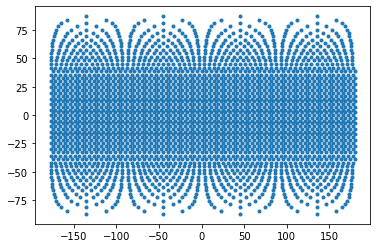

In [10]:
from gprm.GPlatesReconstructionModel import PointDistributionOnSphere
# generate the evenly distributed points that we will use to define the 'bins' for the spatial binning
# Note that the number N must be a power of 2. The higher the number, the denser the points
equal_area_points = PointDistributionOnSphere(distribution_type='healpix',N=16)
plt.plot(equal_area_points.longitude, equal_area_points.latitude,'.')
len(equal_area_points.longitude)
    

In [11]:
from gprm import ReconstructionModel
import get_distances_for_dataframe as gdfd
# This function will take a set of partitioned points, reconstruct them back to a specified time,
# then determine the number of points within each spatial bin based on the bin centers created above
def get_binned_distances(partitioned_df, reconstruction_model, reconstruction_time):
    rlo,rla,rd = myfunc.distance_to_point_features(partitioned_df, reconstruction_model, reconstruction_time)
    bin_counts = equal_area_points.point_feature_heatmap(
        [pygplates.PointOnSphere(point) for point in zip(rla,rlo)])
    return bin_counts

def wedges_to_gmt2(x,y,wedge_fractions,wedge_colors,legends):
    row_sums = np.sum(wedge_fractions,axis=1)
    normed_rows = np.divide(wedge_fractions,row_sums[:,np.newaxis])
    cumulative_angles = np.hstack((np.zeros((len(x),1)),np.cumsum(normed_rows, axis=1))) * 360.
    for row in range(len(x)):
        for i,wedge_color in enumerate(wedge_colors):
            start_angle = cumulative_angles[row,i]
            stop_angle = cumulative_angles[row,i+1]
            with open('tmp.xyz', 'w') as output_file:
                output_file.write(' '.join(str(item) for item in (x[row],y[row],start_angle,stop_angle)) + '\n')
            fig.plot(data='tmp.xyz', style='w0.1c', color=wedge_color, label=legends[i], transparency='20')
        #fig.legend(spec=None, position='JTR+jTR+o0.2c', box='+gwhite+p0.2p') 

# fig2

In [12]:
import public
active_rifts = public.fetch_active_rifts()
inactive_rifts = public.fetch_inactive_rifts()
active_passive_margin = public.fetch_active_passive_margin()
inactive_passive_margin = public.fetch_inactive_passive_margin()

C:\Users\84746\anaconda3\envs\pygmt\lib\site-packages\pygmt\helpers\decorators.py:873: SyntaxWarning: Short-form parameter (t) is not recommended. Use long-form parameter 'transparency' instead.
  return module_func(*args, **kwargs)
C:\Users\84746\AppData\Local\Temp/ipykernel_22652/2700712736.py:64: SyntaxWarning: Short-form parameter (t) is not recommended. Use long-form parameter 'transparency' instead.
  fig.basemap(region=[0, 2, 0, 1], projection="t0/3c", frame=True, t="100")
text [WARNING]: Representation of font type not recognized. Using default.
text [WARNING]: Representation of font type not recognized. Using default.
text [WARNING]: Representation of font type not recognized. Using default.
text [WARNING]: Representation of font type not recognized. Using default.
text [WARNING]: Representation of font type not recognized. Using default.
text [WARNING]: Representation of font type not recognized. Using default.
text [WARNING]: Representation of font type not recognized. Using

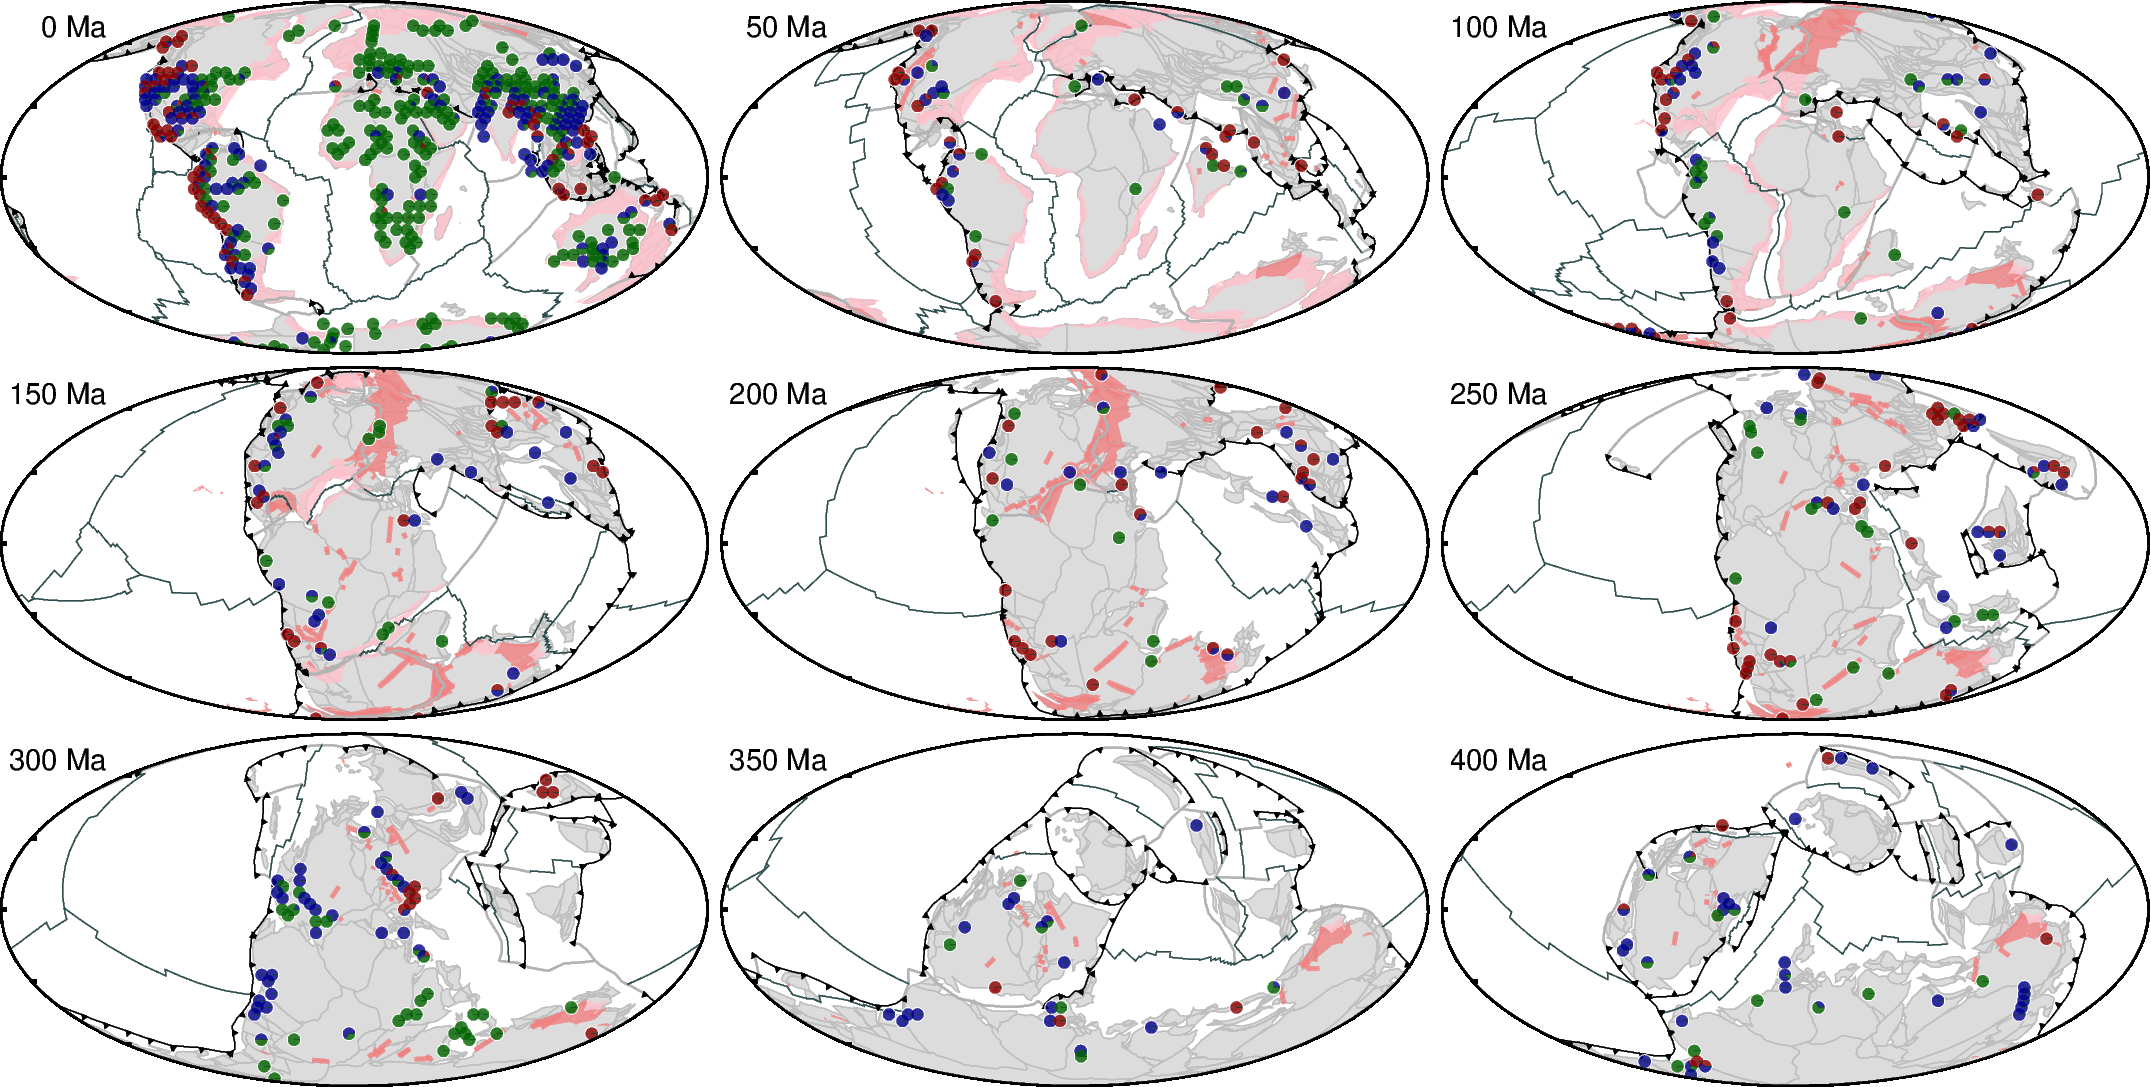

In [13]:
#from gprm.utils import paleotopography as pt          
from gprm import ReconstructionModel
import pygmt

fig = pygmt.Figure()
anchor_plate_id = 0
region='d' 
projection= 'W6c' 
frame = 'f'

reconstruction_times = [0.,50.,100.,150.,200.,250.,300.,350.,400.]
shift_x = ['6.1c','6.1c','-12.2c','6.1c','6.1c','-12.2c','6.1c','6.1c','0.']
shift_y = ['0.','0.','-3.1c','0.','0.','-3.1c','0.','0.','0.']

passive_margins1 = active_rifts
passive_margins2 = inactive_rifts
passive_margins3 = active_passive_margin
passive_margins4 = inactive_passive_margin

for k, reconstruction_time in enumerate(reconstruction_times): 
    SN_rifts = []
    pygplates.reconstruct(passive_margins1, Y2019.rotation_model, SN_rifts, reconstruction_time)
    reconstructed_passive_margins = []
    pygplates.reconstruct(passive_margins3, Y2019.rotation_model, reconstructed_passive_margins, reconstruction_time)
    reconstructed_inactive_passive_margins = []
    pygplates.reconstruct(passive_margins4, Y2019.rotation_model, reconstructed_inactive_passive_margins, reconstruction_time)
    
    fig.basemap(region=region, projection=projection, frame=frame)
    reconstructed_continents = Y2019.polygon_snapshot('continents', reconstruction_time)
    reconstructed_plates = Y2019.plate_snapshot(reconstruction_time)
    reconstructed_continents.plot(fig, color='Gainsboro',pen='gray', anchor_plate_id=anchor_plate_id)

    for SN_rift in SN_rifts:
        geom_array = SN_rift.get_reconstructed_geometry().to_lat_lon_array()
        fig.plot(x=geom_array[:,1],y=geom_array[:,0], color='LightCoral',pen='1,LightCoral', t='20')
    for reconstructed_passive_margin in reconstructed_passive_margins:
        geom_array = reconstructed_passive_margin.get_reconstructed_geometry().to_lat_lon_array()
        fig.plot(x=geom_array[:,1],y=geom_array[:,0], color='LightCoral', transparency='20')
    for reconstructed_inactive_passive_margin in reconstructed_inactive_passive_margins:
        geom_array = reconstructed_inactive_passive_margin.get_reconstructed_geometry().to_lat_lon_array()
        fig.plot(x=geom_array[:,1],y=geom_array[:,0], color='pink', transparency='20')  
        
    reconstructed_plates.plot_other_boundaries(fig)        
    reconstructed_plates.plot_mid_ocean_ridges(fig,pen='DarkSlateGray')
    reconstructed_plates.plot_subduction_zones(fig, gap=6, size=1.2)
        
    A_bin_counts = get_binned_distances(partitioned_A, reconstruction_model, reconstruction_time)
    B_bin_counts = get_binned_distances(partitioned_B, reconstruction_model, reconstruction_time)
    C_bin_counts = get_binned_distances(partitioned_C, reconstruction_model, reconstruction_time)
    
    ratios2 = np.empty(shape=[0, 3])
    lonr = []
    latr = []
    for i in range(equal_area_points.latitude.shape[0]):
        ratios = np.vstack([A_bin_counts[i],B_bin_counts[i],C_bin_counts[i]]).T
        if np.any(ratios>0):
            ratios2 = np.append(ratios2, ratios, axis=0)
            lonr.append(equal_area_points.longitude[i])
            latr.append(equal_area_points.latitude[i])
    fig.plot(x=lonr, y=latr, pen='white', style="c0.11c")
    wedges_to_gmt2(lonr,latr,ratios2,['darkred','darkblue','darkgreen'],['A','B','C'])
    
    fig.basemap(region=region, projection=projection, frame=frame)
    fig.basemap(region=[0, 2, 0, 1], projection="t0/3c", frame=True, transparency="100")
    fig.text(x=0.3, y=0.9, text=str(int(reconstruction_time))+" Ma", font=["7p,Arial",'black'],justify=['RB'])
    #fig.text(x=1.99, y=0.1, text="Y2019", angle=None, font=["7p,Arial",'black'], justify=['RB'])
    fig.shift_origin(xshift=shift_x[k], yshift=shift_y[k])
    
fig.savefig('plots/figures/Figure3.png', dpi=600)
fig.savefig('plots/figures/Figure3.pdf')
fig.show() 
